### INTRODUCTION:

Canada contains the world's eighth largest Indian diaspora. The highest concentrations of Indian Canadians are found in the provinces of Ontario and British Columbia, followed by growing communities in Alberta and Quebec as well, with the majority of them being foreign-born.
The demographics of Toronto, Ontario, Canada make Toronto one of the most multicultural and multiracial cities in the world. In 2016, 51.5% of the residents of the city proper belonged to a visible minority group, compared with 49.1% in 2011, and 13.6% in 1981. Toronto also has established ethnic neighbourhoods such as the multiple Chinatowns, Corso Italia, Little Italy, Little India, Greektown, Koreatown, Little Jamaica, Little Portugal and Roncesvalles, which celebrate the city's multiculturalism.
As people all over the world are liking Indian cuisine, so why not explore some of the best locations for Indian restaurants throughout Toronto. Potentially, the owner of the new Indian restaurant can have great success and huge profit. However, as for starting off a new business, one must be aware of the consequences if things are not implemented strategically or whether or not the business will be profitable. So, a few points should be considered for opening a new business. In our case, an Indian restaurant. Thus, the main idea behind for the attempt of this project is to answer a few questions such as -” Where should the investor invest to open an Indian restaurant?” and “Where should I go if I want to experience great Indian cuisines?” 


### DATA:

In order to answer the above questions, data on Toronto City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.
Toronto City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the open data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### METHODOLOGY:

• Data will be collected from  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Indian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphs.

### PROBLEM STATEMENT:

- Where should the investor invest to open an Indian restaurant
- Where should I go if I want to experience great Indian cuisines?

#### Importing the required libraries:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from urllib.request import Request, urlopen
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import requests
import folium
import os
from pandas.io.json import json_normalize

print("Libraries imported")

Libraries imported


In [2]:
pd.set_option('display.max_columns',None)

In [3]:
pd.set_option('display.max_rows',None)

#### Function for scraping the open source data into a dataframe:

In [4]:
def web_scraping():
    url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
    req = Request(url)
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage)
    table_contents=[]
    table=soup.find('table')
    for row in table.findAll('td'):
        cell = {}
        if row.span.text=='Not assigned':
            pass
        else:
            cell['PostalCode'] = row.p.text[:3]
            cell['Borough'] = (row.span.text).split('(')[0]
            cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
            table_contents.append(cell)
    df = pd.DataFrame(table_contents)
    df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
    return df

In [5]:
frame = web_scraping()

In [6]:
frame.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
frame[frame['Borough'] == 'Not assigned']

,PostalCode,Borough,Neighborhood


In [8]:
frame[frame['PostalCode'] == 'M5A']

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Geocoding the location based on Postal code in Toronto:

In [9]:
import geocoder

In [10]:
def geocoding_df(df):
    df['Address']=df['PostalCode']+',Toronto,Ontario'
    lat=[]
    long=[]
    count = 0
    
    for i in df['Address']:
        geo=geocoder.arcgis(i)
#         print(i,': Longitude',geo.x,'Latitude',geo.y)
        long.append(geo.x)
        lat.append(geo.y)
        count += 1
    df['Longitude'] = long
    df['Latitude'] = lat
    return df

In [11]:
frame = geocoding_df(frame)

KeyboardInterrupt: 

In [ ]:
frame

#### Saving the dataframe to excel file:

In [12]:
df = pd.read_excel(r'D:/Vaishali/Data/Geocoded_Data_Toronto.xlsx')

In [13]:
frame = df[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]

In [14]:
frame.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


In [15]:
frame.shape

(103, 5)

### VISUALISING THE DATA:

#### 1. Neighborhoods per Borough:

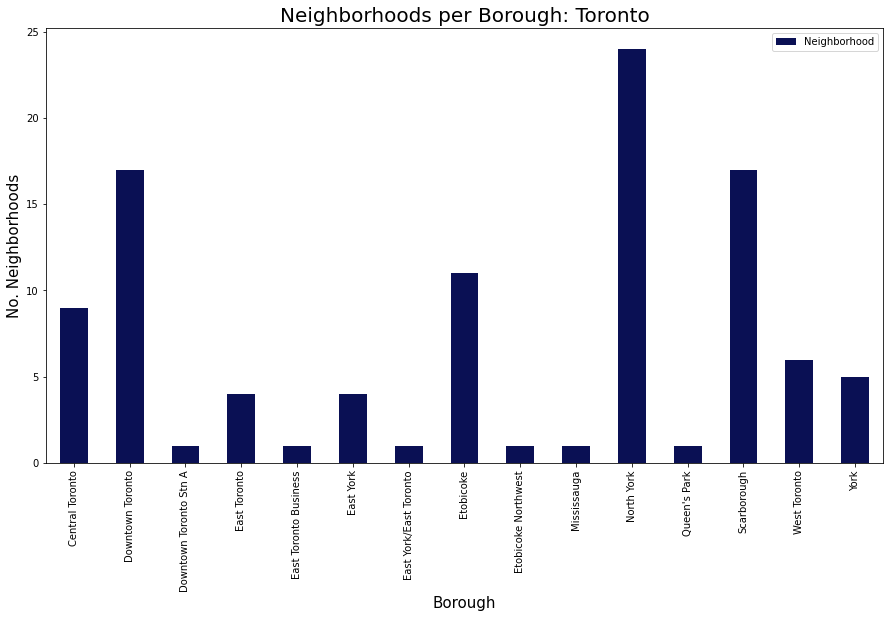

In [46]:
frame.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(15,8), color='#0A1054')
plt.title('Neighborhoods per Borough: Toronto', fontsize = 20)
plt.xlabel('Borough', fontsize = 15, loc='center')
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

### Foursquare API for fetching venue & venue details:


In [19]:
CLIENT_ID = 'DNURYOV22UE3XENBYDHZ3VDI5Z1LTIUBWE3TN5LGM1ZYIMZW' # your Foursquare ID
CLIENT_SECRET = 'IUB2IBEMEPOMSGORIMSYG3VWMOKOWDNMMYJTBPMXZ3R4OKYY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Foursquare API credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Foursquare API credentails:
CLIENT_ID: DNURYOV22UE3XENBYDHZ3VDI5Z1LTIUBWE3TN5LGM1ZYIMZW
CLIENT_SECRET:IUB2IBEMEPOMSGORIMSYG3VWMOKOWDNMMYJTBPMXZ3R4OKYY


##### Function to get venues based on the geocoordinates:

In [20]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Function to get venue details i.e., ratings, tips, count, likes:

In [21]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [22]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest=pd.DataFrame(columns=column_names)
count=1

In [23]:
frame = frame[['Borough','Neighborhood','Latitude','Longitude']]

In [24]:
for row in frame.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(frame),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest = indian_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Restaurants in Parkwoods, North York:0
['North York', 'Parkwoods', 43.75245000000007, -79.32990999999998]
( 2 / 103 ) Indian Restaurants in Victoria Village, North York:0
['North York', 'Victoria Village', 43.73057000000006, -79.31305999999995]
( 3 / 103 ) Indian Restaurants in Regent Park, Harbourfront, Downtown Toronto:0
['Downtown Toronto', 'Regent Park, Harbourfront', 43.65512, -79.3626399999999]
( 4 / 103 ) Indian Restaurants in Lawrence Manor, Lawrence Heights, North York:1
['North York', 'Lawrence Manor, Lawrence Heights', 43.72327, -79.4504199999999]
( 5 / 103 ) Indian Restaurants in Ontario Provincial Government, Queen's Park:0
["Queen's Park", 'Ontario Provincial Government', 43.66253000000006, -79.39187999999996]
( 6 / 103 ) Indian Restaurants in Islington Avenue, Etobicoke:0
['Etobicoke', 'Islington Avenue', 43.66263000000004, -79.52830999999998]
( 7 / 103 ) Indian Restaurants in Malvern, Rouge, Scarborough:0
['Scarborough', 'Malvern, Rouge', 43.811390000

( 53 / 103 ) Indian Restaurants in Willowdale, Newtonbrook, North York:0
['North York', 'Willowdale, Newtonbrook', 43.79182000000003, -79.41371999999996]
( 54 / 103 ) Indian Restaurants in Downsview Central, North York:0
['North York', 'Downsview Central', 43.73224000000005, -79.50177999999994]
( 55 / 103 ) Indian Restaurants in Studio District, East Toronto:0
['East Toronto', 'Studio District', 43.66213000000005, -79.33496999999994]
( 56 / 103 ) Indian Restaurants in Bedford Park, Lawrence Manor East, North York:1
['North York', 'Bedford Park, Lawrence Manor East', 43.73545000000007, -79.41915999999998]
( 57 / 103 ) Indian Restaurants in Del Ray, Mount Dennis, Keelsdale and Silverthorn, York:0
['York', 'Del Ray, Mount Dennis, Keelsdale and Silverthorn', 43.69517000000008, -79.48396999999994]
( 58 / 103 ) Indian Restaurants in Humberlea, Emery, North York:0
['North York', 'Humberlea, Emery', 43.73367000000007, -79.53768999999994]
( 59 / 103 ) Indian Restaurants in Birch Cliff, Cliffsid

( 101 / 103 ) Indian Restaurants in Enclave of M4L, East Toronto Business:1
['East Toronto Business', 'Enclave of M4L', 43.64869000000004, -79.38543999999996]
( 102 / 103 ) Indian Restaurants in Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East, Etobicoke:0
['Etobicoke', "Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East", 43.63278000000003, -79.48944999999998]
( 103 / 103 ) Indian Restaurants in Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, Etobicoke:0
['Etobicoke', 'Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West', 43.62513000000007, -79.52680999999995]


In [25]:
indian_rest.to_excel(r'D:\Vaishali\Data\IndianRestaurants.xlsx', index=False)

##### List of Indian Restaurants in Toronto:

In [26]:
indian_rest = pd.read_excel(r'D:\Vaishali\Data\IndianRestaurants.xlsx')
indian_rest

,Borough,Neighborhood,ID,Name
0,North York,"Lawrence Manor, Lawrence Heights",4fca1f88e4b07c8e3ddb22bf,Amaya Express
1,Downtown Toronto,Berczy Park,526c649111d2200c3216dbc2,Bindia Indian Bistro
2,East York,Thorncliffe Park,4bed9f2fbac3c9b6ad93fee9,Hakka Garden
3,North York,"Bedford Park, Lawrence Manor East",4d796616542ab1f75eb87c41,The Copper Chimney
4,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India
5,Mississauga,Enclave of L4W,4ad8a5a7f964a5203c1321e3,Little India Restaurant
6,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro
7,West Toronto,"Runnymede, Swansea",525e1812498e2c14b4d80b8b,Bukhara indian cuisine
8,Downtown Toronto Stn A,Enclave of M5E,4ad8a5a7f964a5203c1321e3,Little India Restaurant
9,Downtown Toronto,"St. James Town, Cabbagetown",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory


In [27]:
indian_rest.shape

(12, 4)

#### Visualising Indian Restaurants per Borough:

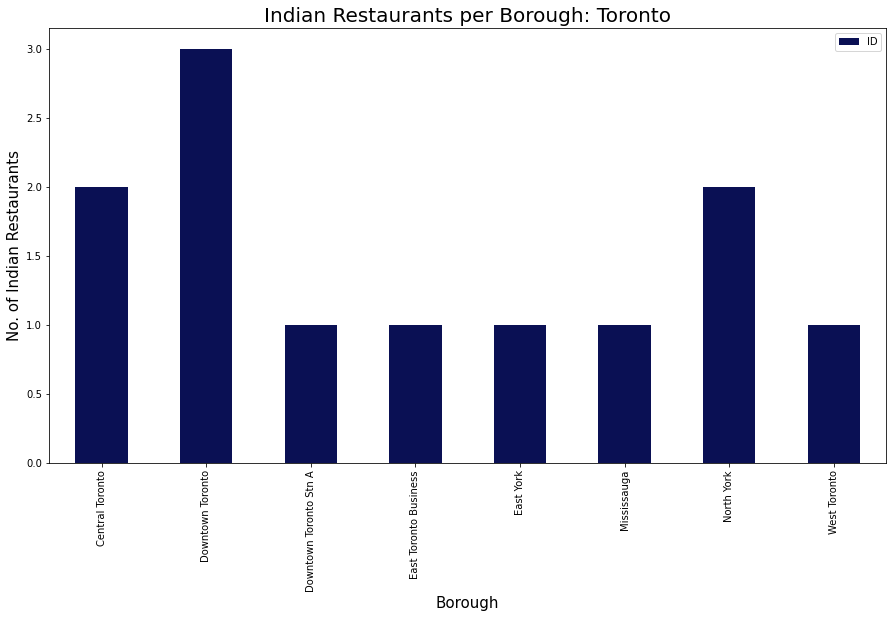

In [47]:
indian_rest.groupby('Borough')['ID'].count().plot.bar(figsize=(15,8), color='#0A1054')
plt.title('Indian Restaurants per Borough: Toronto', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 90)
plt.legend()
plt.show()


#### Visualising Indian Restaurants per Neighborhood: Toronto

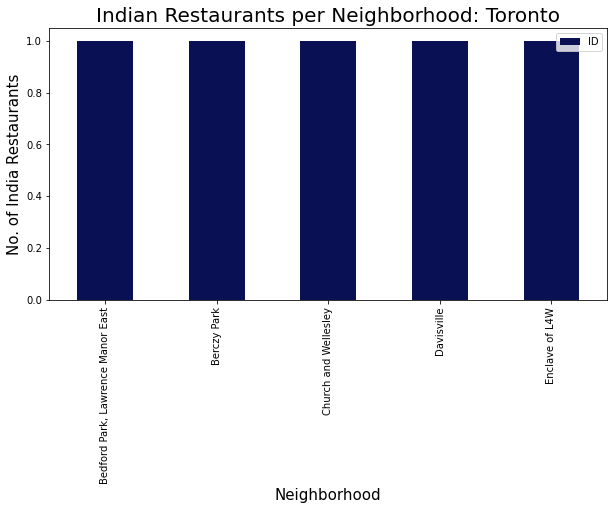

In [48]:
top = 5
indian_rest.groupby('Neighborhood')['ID'].count().nlargest(top).plot.bar(figsize=(10,5), color='#0A1054')
plt.title('Indian Restaurants per Neighborhood: Toronto', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of India Restaurants', fontsize=15)
plt.xticks(rotation =90)
plt.legend()
plt.show()

In [49]:
indian_rest[indian_rest['Neighborhood']=='Bedford Park, Lawrence Manor East']

,Borough,Neighborhood,ID,Name
3,North York,"Bedford Park, Lawrence Manor East",4d796616542ab1f75eb87c41,The Copper Chimney


##### Fetching Ratings, Likes & Tips of Indian Restaurants:

In [31]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest),')','processed')
    indian_rest_stats = indian_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '61192c7b27d7bf5817f3fe76'}, 'response': {'venue': {'id': '4fca1f88e4b07c8e3ddb22bf', 'name': 'Amaya Express', 'contact': {}, 'location': {'address': '3401 Dufferin St.', 'crossStreet': 'In Yorkdale Mall Foodcourt', 'lat': 43.726163460557856, 'lng': -79.45209535764381, 'labeledLatLngs': [{'label': 'display', 'lat': 43.726163460557856, 'lng': -79.45209535764381}], 'postalCode': 'M6A 2T9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3401 Dufferin St. (In Yorkdale Mall Foodcourt)', 'Toronto ON M6A 2T9', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/amaya-express/4fca1f88e4b07c8e3ddb22bf', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'm

{'meta': {'code': 200, 'requestId': '61192c7c48f0cd013ac31bb3'}, 'response': {'venue': {'id': '4bed9f2fbac3c9b6ad93fee9', 'name': 'Hakka Garden', 'contact': {}, 'location': {'address': '25 Overlea Blvd. Unit 7', 'lat': 43.704578351261326, 'lng': -79.34977027417523, 'labeledLatLngs': [{'label': 'display', 'lat': 43.704578351261326, 'lng': -79.34977027417523}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['25 Overlea Blvd. Unit 7', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/hakka-garden/4bed9f2fbac3c9b6ad93fee9', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'coun

{'meta': {'code': 200, 'requestId': '61192c7f31a83047e2927a76'}, 'response': {'venue': {'id': '4c62c59ce1621b8dd0332453', 'name': 'Roti Cuisine of India', 'contact': {'phone': '4169689366', 'formattedPhone': '(416) 968-9366'}, 'location': {'address': '308 Dupont St.', 'crossStreet': 'at Walmer Rd.', 'lat': 43.67461834990478, 'lng': -79.40824866273744, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67461834990478, 'lng': -79.40824866273744}], 'postalCode': 'M5R 2X8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['308 Dupont St. (at Walmer Rd.)', 'Toronto ON M5R 2X8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/roti-cuisine-of-india/4c62c59ce1621b8dd0332453', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '61192c8040ea3e1e45a86e37'}, 'response': {'venue': {'id': '4ad8a5a7f964a5203c1321e3', 'name': 'Little India Restaurant', 'contact': {'phone': '4162059836', 'formattedPhone': '(416) 205-9836', 'twitter': 'littleindiadine', 'facebook': '124259190949118', 'facebookUsername': 'LittleIndiaDine', 'facebookName': 'Little India Restaurant'}, 'location': {'address': '255 Queen St. W', 'crossStreet': 'Queen and University', 'lat': 43.65031880877208, 'lng': -79.38899760320798, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65031880877208, 'lng': -79.38899760320798}], 'postalCode': 'M5V 1Z4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['255 Queen St. W (Queen and University)', 'Toronto ON M5V 1Z4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/littleindiadine', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '61192c81020fd840164da772'}, 'response': {'venue': {'id': '5169d445e4b07de190b5c3d6', 'name': 'Marigold Indian Bistro', 'contact': {'phone': '6477480220', 'formattedPhone': '(647) 748-0220', 'twitter': 'marigoldbistro', 'facebook': '528437103943169', 'facebookUsername': 'Marigoldbistro', 'facebookName': 'Marigold Indian Bistro'}, 'location': {'address': '552 Mount Pleasant Rd.', 'lat': 43.702880859375, 'lng': -79.38800811767578, 'labeledLatLngs': [{'label': 'display', 'lat': 43.702880859375, 'lng': -79.38800811767578}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['552 Mount Pleasant Rd.', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/marigoldbistro', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '61192c82ab8b7b6829d03b64'}, 'response': {'venue': {'id': '525e1812498e2c14b4d80b8b', 'name': 'Bukhara indian cuisine', 'contact': {'phone': '4165515199', 'formattedPhone': '(416) 551-5199'}, 'location': {'address': '2241A Bloor Street West', 'crossStreet': 'Runnymede & Bloor', 'lat': 43.65110529992475, 'lng': -79.47710362509072, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65110529992475, 'lng': -79.47710362509072}], 'postalCode': 'M6S 1N7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2241A Bloor Street West (Runnymede & Bloor)', 'Toronto ON M6S 1N7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/bukhara-indian-cuisine/525e1812498e2c14b4d80b8b', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], '

{'meta': {'code': 200, 'requestId': '61192c84ba16570876614248'}, 'response': {'venue': {'id': '4c8c21fdf0ce236ab28e15ef', 'name': 'Butter Chicken Factory', 'contact': {'phone': '4169647583', 'formattedPhone': '(416) 964-7583'}, 'location': {'address': '556 Parliament St.', 'crossStreet': 'at Prospect St.', 'lat': 43.66707247004843, 'lng': -79.36918422958169, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66707247004843, 'lng': -79.36918422958169}], 'postalCode': 'M4K 1P6', 'cc': 'CA', 'neighborhood': 'Cabbagetown', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['556 Parliament St. (at Prospect St.)', 'Toronto ON M4K 1P6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/butter-chicken-factory/4c8c21fdf0ce236ab28e15ef', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '61192c85232d424860f17db9'}, 'response': {'venue': {'id': '4bedf8b5e24d20a17b567214', 'name': 'Kothur Indian Cuisine', 'contact': {'phone': '4169260953', 'formattedPhone': '(416) 926-0953'}, 'location': {'address': '649 Yonge St.', 'lat': 43.66787229558206, 'lng': -79.38565911153148, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66787229558206, 'lng': -79.38565911153148}], 'postalCode': 'M4Y', 'cc': 'CA', 'neighborhood': 'Church and Wellesley', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['649 Yonge St.', 'Toronto ON M4Y', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kothur-indian-cuisine/4bedf8b5e24d20a17b567214', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 19}, '

In [69]:
indian_rest_stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,North York,"Lawrence Manor, Lawrence Heights",4fca1f88e4b07c8e3ddb22bf,Amaya Express,8.0,6.3,3.0
1,Downtown Toronto,Berczy Park,526c649111d2200c3216dbc2,Bindia Indian Bistro,30.0,7.3,14.0
2,East York,Thorncliffe Park,4bed9f2fbac3c9b6ad93fee9,Hakka Garden,9.0,6.3,12.0
3,North York,"Bedford Park, Lawrence Manor East",4d796616542ab1f75eb87c41,The Copper Chimney,14.0,7.3,15.0
4,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India,39.0,8.4,19.0
5,Mississauga,Enclave of L4W,4ad8a5a7f964a5203c1321e3,Little India Restaurant,127.0,7.3,73.0
6,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro,11.0,8.0,11.0
7,West Toronto,"Runnymede, Swansea",525e1812498e2c14b4d80b8b,Bukhara indian cuisine,6.0,7.0,3.0
8,Downtown Toronto Stn A,Enclave of M5E,4ad8a5a7f964a5203c1321e3,Little India Restaurant,127.0,7.3,73.0
9,Downtown Toronto,"St. James Town, Cabbagetown",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,16.0,7.9,11.0


In [33]:
indian_rest_stats.to_excel("D:Vaishali/Data/IndianRestaurantsStats.xlsx", index=False)

##### Checking the statistical information of the Indian restaurant dataframe:

In [34]:
indian_rest_stats.shape

(12, 7)

In [35]:
indian_rest_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       12 non-null     object 
 1   Neighborhood  12 non-null     object 
 2   ID            12 non-null     object 
 3   Name          12 non-null     object 
 4   Likes         12 non-null     object 
 5   Rating        12 non-null     float64
 6   Tips          12 non-null     object 
dtypes: float64(1), object(6)
memory usage: 800.0+ bytes


In [36]:
indian_rest_stats['Likes'] = indian_rest_stats['Likes'].astype('float64')
indian_rest_stats['Tips'] = indian_rest_stats['Tips'].astype('float64')
indian_rest_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       12 non-null     object 
 1   Neighborhood  12 non-null     object 
 2   ID            12 non-null     object 
 3   Name          12 non-null     object 
 4   Likes         12 non-null     float64
 5   Rating        12 non-null     float64
 6   Tips          12 non-null     float64
dtypes: float64(3), object(4)
memory usage: 800.0+ bytes


In [37]:
indian_rest_stats.describe()

,Likes,Rating,Tips
count,12.000000,12.000000,12.000000
mean,44.166667,7.366667,27.166667
std,50.820242,0.645732,28.086986
min,6.000000,6.300000,3.000000
25%,10.500000,7.225000,11.000000
50%,16.000000,7.300000,14.500000
75%,61.000000,7.925000,32.500000
max,127.000000,8.400000,73.000000


In [38]:
indian_rest_stats.iloc[indian_rest_stats['Likes'].idxmax()]

Borough                      Mississauga
Neighborhood              Enclave of L4W
ID              4ad8a5a7f964a5203c1321e3
Name             Little India Restaurant
Likes                              127.0
Rating                               7.3
Tips                                73.0
Name: 5, dtype: object

In [39]:
indian_rest_stats.iloc[indian_rest_stats['Rating'].idxmax()]

Borough                             Central Toronto
Neighborhood    The Annex, North Midtown, Yorkville
ID                         4c62c59ce1621b8dd0332453
Name                          Roti Cuisine of India
Likes                                          39.0
Rating                                          8.4
Tips                                           19.0
Name: 4, dtype: object

In [40]:
indian_rest_stats.iloc[indian_rest_stats['Tips'].idxmax()]

Borough                      Mississauga
Neighborhood              Enclave of L4W
ID              4ad8a5a7f964a5203c1321e3
Name             Little India Restaurant
Likes                              127.0
Rating                               7.3
Tips                                73.0
Name: 5, dtype: object

##### Dataframe based on average rating of the Indian restaurant in a neighbourhood:

In [42]:
neighborhood_stats=indian_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
10,"The Annex, North Midtown, Yorkville",8.4
2,Church and Wellesley,8.0
3,Davisville,8.0
9,"St. James Town, Cabbagetown",7.9
0,"Bedford Park, Lawrence Manor East",7.3
1,Berczy Park,7.3
4,Enclave of L4W,7.3
5,Enclave of M4L,7.3
6,Enclave of M5E,7.3
8,"Runnymede, Swansea",7.0


##### Dataframe based on average rating of the Indian restaurant in a borough:

In [62]:
borough_stats=indian_rest_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']
borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
0,Central Toronto,8.200000
1,Downtown Toronto,7.733333
2,Downtown Toronto Stn A,7.300000
3,East Toronto Business,7.300000
5,Mississauga,7.300000
7,West Toronto,7.000000
6,North York,6.800000
4,East York,6.300000


#### Visualising average rating of Indian restaurants for each borough:

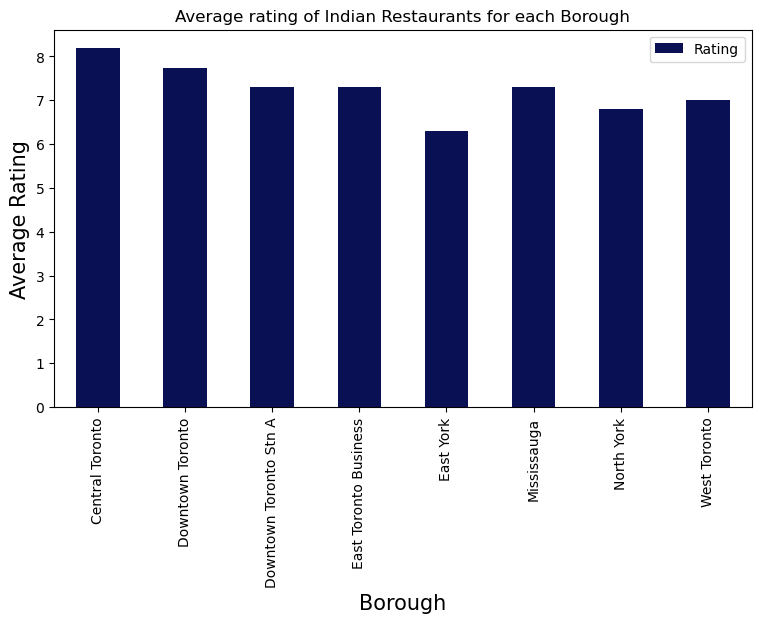

In [50]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats.groupby('Borough').mean()['Rating'].plot(kind='bar', color='#0A1054')
plt.legend()
plt.show()

In [63]:
neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=7.0]
neighborhood_stats

,Borough_x,Neighborhood,Latitude_x,Longitude_x,Average Rating,Borough_y,Latitude_y,Longitude_y
0,North York,"Bedford Park, Lawrence Manor East",43.73545,-79.41916,7.3,North York,43.73545,-79.41916
1,Downtown Toronto,Berczy Park,43.64536,-79.37306,7.3,Downtown Toronto,43.64536,-79.37306
2,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,8.0,Downtown Toronto,43.66659,-79.38133
3,Central Toronto,Davisville,43.70340,-79.38659,8.0,Central Toronto,43.70340,-79.38659
4,Mississauga,Enclave of L4W,43.64869,-79.38544,7.3,Mississauga,43.64869,-79.38544
5,East Toronto Business,Enclave of M4L,43.64869,-79.38544,7.3,East Toronto Business,43.64869,-79.38544
6,Downtown Toronto Stn A,Enclave of M5E,43.64869,-79.38544,7.3,Downtown Toronto Stn A,43.64869,-79.38544
7,West Toronto,"Runnymede, Swansea",43.64982,-79.47548,7.0,West Toronto,43.64982,-79.47548
8,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,7.9,Downtown Toronto,43.66788,-79.36649
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40452,8.4,Central Toronto,43.67484,-79.40452


In [64]:
neighborhood_stats=pd.merge(neighborhood_stats,frame, on='Neighborhood')
neighborhood_stats=neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,North York,"Bedford Park, Lawrence Manor East",43.73545,-79.41916,7.3
1,Downtown Toronto,Berczy Park,43.64536,-79.37306,7.3
2,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,8.0
3,Central Toronto,Davisville,43.70340,-79.38659,8.0
4,Mississauga,Enclave of L4W,43.64869,-79.38544,7.3
5,East Toronto Business,Enclave of M4L,43.64869,-79.38544,7.3
6,Downtown Toronto Stn A,Enclave of M5E,43.64869,-79.38544,7.3
7,West Toronto,"Runnymede, Swansea",43.64982,-79.47548,7.0
8,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,7.9
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40452,8.4


### PLOTTING THE RESTAURANTS ON THE FOLIUM MAPS:

In [65]:
i_map = folium.Map(location=[43.66659,-79.38133], zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [66]:
neighborhood_stats['Label']=neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(i_map)        
# add ratings to map
i_map.add_child(rating)

In [68]:
neighborhood_stats.sort_values(by='Average Rating', ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.67484,-79.40452,8.4,"The Annex, North Midtown, Yorkville, Central T..."
2,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,8.0,"Church and Wellesley, Downtown Toronto(8.0)"
3,Central Toronto,Davisville,43.70340,-79.38659,8.0,"Davisville, Central Toronto(8.0)"
8,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,7.9,"St. James Town, Cabbagetown, Downtown Toronto(..."
0,North York,"Bedford Park, Lawrence Manor East",43.73545,-79.41916,7.3,"Bedford Park, Lawrence Manor East, North York(..."
1,Downtown Toronto,Berczy Park,43.64536,-79.37306,7.3,"Berczy Park, Downtown Toronto(7.3)"
4,Mississauga,Enclave of L4W,43.64869,-79.38544,7.3,"Enclave of L4W, Mississauga(7.3)"
5,East Toronto Business,Enclave of M4L,43.64869,-79.38544,7.3,"Enclave of M4L, East Toronto Business(7.3)"
6,Downtown Toronto Stn A,Enclave of M5E,43.64869,-79.38544,7.3,"Enclave of M5E, Downtown Toronto Stn A(7.3)"
7,West Toronto,"Runnymede, Swansea",43.64982,-79.47548,7.0,"Runnymede, Swansea, West Toronto(7.0)"


### RESULTS & CONCLUSION:

Central Toronto and Downtown Toronto have the best rated Indian restaurants on average. West Toronto has the least amount of Indian restaurants per borough. However, of note,The Annex, North Midtown, Yorkville in Central Toronto has the highest number of Indian Restaurants in all of Toronto. Despite Downtown Toronto having the least number of neighborhoods in all the boroughs, it has the most number of Indian restaurants. Based on the above information, I would state that Central Toronto and Downtown Toronto are the best locations for Indian cuisine in Toronto. To have the best shot of success, I would open a Indian restaurant in Central Toronto. Central Toronto has multiple neighborhoods with average ratings exceeding 7.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Downtown Toronto, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to Little India Restaurant in Missisuaga,Downtown Toronto Stn A or East Toronto Business for the best Indian food based on 127 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.